http://kylehardman.com/BlogPosts/View/7


The Watanabe-Akaike Information Criterion (WAIC) is a way of measuring the fit of Bayesian models. It is conceptually similar to AIC and BIC. Like AIC and BIC, lower values of WAIC indicate a better model fit. I will describe how to calculate WAIC for the case in which unknown parameters are estimated with a Gibbs sampler, which produces samples from the posterior distribution of the parameters. WAIC can be calculated with these posterior chains and some other fairly accessible information. Like my [DIC tutorial](http://kylehardman.com/BlogPosts/View/6), my knowledge about WAIC comes from [Bayesian Data Analysis, Third Edition](http://www.amazon.com/Bayesian-Analysis-Chapman-Statistical-Science/dp/1439840954/ref=sr_1_1?s=books&ie=UTF8&qid=1458857289&sr=1-1&keywords=bayesian+data+analysis) by Gelman, Carlin, Stern, Dunson, Vehtari, and Rubin. What I have done is to show you how to calculate WAIC for an example model and data set, R code included, to make it all concrete.

One very nice feature of WAIC is that it does not rely on posterior means of parameters, like DIC does. For some models, some parameters will either not have a usable posterior mean (e.g. a discrete indicator parameter that is either 0 or 1) or will not have a meaningful posterior mean (e.g. a multi-modal posterior). In such cases, using the posterior mean is impossible or unwarranted, so it is more appropriate to use a model fit statistic, like WAIC, that does not use the posterior mean.

I am focused on a case in which the parameters are estimated with a Gibbs sampler, so four things are required to calculate WAIC:

1. The data, denoted $y$.
2. A Bayesian model for the data with some parameter vector $\theta$.
3. Samples from the posterior distribution of the parameters of the model.
4. The likelihood function, that gives the likelihood of the data given parameters, typically denoted $p(y|\theta)$.

Item 2 is not used directly, but items 3 and 4 depend on it. The data, model, and sampling procedure are all identical to those that I used in my [DIC tutorial](http://kylehardman.com/BlogPosts/View/6). The likelihood function is conceptually the same, but the exact way in which it is programmmed is different in this case than for DIC. You may want to read what I did in my DIC tutorial, up to and including the Likelihood Function section of that post, before continuing.


## Data and Parameter Samples


In [11]:
#Sample a realization from the distribution of mu given
#data (y), assumed known data variance (sigma2), prior mean (mu0), and prior variance (var0).
post_mu = function(y, sigma2, mu0, var0) {
	a = length(y) / sigma2 + 1 / var0
	b = sum(y) / sigma2 + mu0 / var0
	b = b / a
	
	rnorm(1, b, sqrt(1/a))
}

#Sample a realization from the distribution of sigma2 given
#data (y), assumed known data mean (mu), prior shape (a0), and prior rate (b0).
post_sigma2 = function(y, mu, a0, b0) {
	SSE = sum((y - mu)^2)
	
	a = a0 + length(y)/2
	b = b0 + SSE / 2
	
	r = rgamma(1, a, b)
	1/r
}

#Get a matrix of samples from the posterior distribution of mu and sigma2.
#The first column of the matrix is for mu and the second column is for sigma2.
#mu0 and var0 are priors on mu and a0 and b0 are priors on sigma2
getPosteriorSamples = function(iterations, mu0, var0, a0, b0) {
  
  iterations = iterations + 1 #add space for starting values
  mu = rep(0, iterations)
  sigma2 = rep(0, iterations)
  
  #start values
  mu[1] = 0
  sigma2[1] = 20
  
  for (i in 2:iterations) {
    mu[i] = post_mu(y, sigma2[i - 1], mu0, var0)
  
  	sigma2[i] = post_sigma2(y, mu[i], a0, b0)
  }
    
  m = cbind(mu, sigma2)
  m[-1,] #strip off starting values
}


The data, $y$, are 50 deviates from a normal distribution with mean 40 and standard deviation 10.


In [12]:
set.seed(123)
y = rnorm(50, 40, 10)


Using `getPosteriorSamples` (see the [DIC tutorial](http://kylehardman.com/BlogPosts/View/6) for that function) with the data, $y$, and some relatively uninformative settings for the priors, we can obtain posterior chains for the parameters, which are stored in `theta_post`. 

In [13]:
theta_post = getPosteriorSamples(iterations=100000, mu0=0, var0=1000, a0=0.1, b0=0.1)
theta_post[1:5,]

mu,sigma2
40.48808,85.89386
41.88349,83.09866
38.92590,97.38113
41.08069,83.82432
40.55588,79.24317


Each row of `theta_post` is one sample from the posterior distribution of $\mu$ and $\sigma^2$ and is from one iteration of the Gibbs sampler.


## Likelihood Function

The last thing needed to calculate WAIC is the likelihood function. The most convenient single likelihood function to write for the purposes of calculating WAIC is one that takes a single observation from the data set along with a matrix of posterior chains of the parameters. To be clear, this is a likelihood, not a log likelihood, function.


In [14]:
# y_i is one observation from y.
# theta is the whole matrix of samples from the posterior distribution of mu and sigma^2.
likelihood_singleY = function(y_i, theta) {
  #Get the individual parameter vectors out of theta.
  mus = theta[,1]
  sigma2s = theta[,2]
  
  dnorm(y_i, mus, sqrt(sigma2s))
}

In [15]:
l <- likelihood_singleY(40,theta_post)
str(l)

 num [1:100000] 0.043 0.0428 0.0402 0.0433 0.0447 ...




## Calculating WAIC

With the values and functions that I have, it is possible to calculate WAIC. The equation for WAIC is
$$
WAIC = -2 * (LPPD - P)
$$
where $LPPD$ is the log posterior predictive density (to be explained) and $P$ is an estimate of the effective number of free parameters in the model. I use only a small amount of mathematical notation for the following calculations because they are difficult to represent using standard notation (Gelman et al. defined nonstandard notation that they then used for some of the calculations). I instead present the steps of the algorithms. The algorithms can be very concisely represented in R code, which is given following the algorithms.

$LPPD$ is calculated as follows:

1. For each observation in $y$, calculate the likelihood for that observation for each sample of parameters from their posterior distribution (i.e. each row of `theta_post`). This results in a vector of likelihoods, denoted $L$, each element of which is the likelihood for one sample of parameters from the posterior distribution.
2. Take the mean of $L$
3. Take the log of the mean.
4. Take the sum of the log of the mean likelihoods across all observations in $y$.

Thus, $LPPD$ is the sum across observations in $y$ of the log of the mean of the likelihoods of each sample from the posterior distribution of the parameters.

WAIC, like many deviance statistics, has a penalty term related to the flexibility of the model. For WAIC, $P$ is the penality term, which is an estimate of the effective number of free parameters in the model. There are two different ways to estimate $P$, which produce slightly different results. Gelman et al. recommend the second version.

The first estimate of $P$, $P_1$, is calculated as follows:

1. For each observation in $y$, calculate the likelihood vector $L$ in the same way as for $LPPD$.
2. Let $a$ be the log of the mean of $L$ (i.e. the log of the mean likelihood).
3. Let $b$ be the mean of the log of $L$ (i.e. the mean log likelihood).
4. Take the sum of $2 * (a - b)$ across all observations in $y$.

The second estimate of $P$, $P_2$, is calculated as follows:

1. For each observation in $y$, calculate the likelihood vector $L$ in the same way as for $LPPD$.
2. Take the log of $L$, resulting in a vector of log likelihoods.
3. Calculate the sample variance of the log likelihoods.
4. Take the sum of the variances of the log likelihoods across all observations in $y$.

These algorithms are easily implemented in R, as can be seen in the following code. Note that the `log` function takes the log of each element in the vector passed to it and returns a vector of the same length.

In [16]:

# y is the vector of data (this function would need to be modified slightly if y is a matrix)
# theta is a matrix of samples from the posterior distribution of the parameters.
# likeFun is a function that takes two arguments: 
#   a single observation from y and a matrix of posterior chains, theta. 
#   likeFun returns a vector of likelihoods, each corresponding to a row of theta.
#   For a function matching the requirements of likeFun, see likelihood_singleY, defined above.
calculate_WAIC = function(y, theta, likeFun) {
	
	# Initialize accumulator variables that will be added to
	LPPD = 0
	P_1 = 0
	P_2 = 0
	
	for (i in 1:length(y)) {
		
		# Get a vector of likelihoods for this observation in y
		L = likeFun(y[i], theta)
		
		# Calculate LPPD for this observation
		LPPD = LPPD + log( mean(L) )
		
		# Calculate P_1
		a = log( mean(L) )
		b = mean( log(L) )
		
		P_1 = P_1 + 2 * (a - b)
		
		# Calculate P_2
		P_2 = P_2 + var( log(L) )
		
	}
	
	# The two versions of WAIC differ in terms of which P is used
	WAIC_1 = -2 * (LPPD - P_1)
	WAIC_2 = -2 * (LPPD - P_2)
	
	# Return a list containing the results
	list(WAIC_1 = WAIC_1, WAIC_2 = WAIC_2, P_1 = P_1, P_2 = P_2, LPPD = LPPD)
}




## Results

With the data, `y`, the posterior chains, `theta_post`, and the likelihood function, `likelihood_singleY`, the `calculate_WAIC` function can be used as follows.


In [17]:
waic = calculate_WAIC(y, theta_post, likelihood_singleY)
print(waic)

$WAIC_1
[1] 367.1651

$WAIC_2
[1] 367.3309

$P_1
[1] 1.695479

$P_2
[1] 1.778401

$LPPD
[1] -181.8871




`calculate_WAIC` returns a list containing the results of the calculations. Note that there are two versions of the WAIC statistic, each based on a different version of the penality term, $P$. $P$ is an estimate of the effective number of free parameters. In the model, there were 2 free parameters, $\mu$ and $\sigma^2$, so the estimates of $P$ are pretty good.

WAIC itself cannot be interpreted without another model to compare it to, so I will make a comparison model by changing the priors. 





Note that the prior mean that I have been using is $\mu_0 = 0$, which is really wrong, given that the data are centered on 40. This has not been a problem, because the prior variance, $\sigma_0^2$, was very large, making the prior on $\mu$ uninformative. One comparison model can be constructed by having an informative prior on an incorrect $\mu$ by setting $\mu_0 = 0$ and $\sigma^2_0 = 1$.

In [18]:
theta_post_constrained = getPosteriorSamples(10000, mu0=0, var0=1, a0=0.1, b0=0.1)
apply(theta_post_constrained, 2, mean)

mu     sigma2 
   1.19928 1678.30757

As can be seen, a result of making the prior on $\mu$ more informative is that it makes the posterior mean for $\mu$ quite wrong: It should be much higher. Thus, adding this prior constraint on $\mu$ has dramatically changed how the model fits. Let's examine how this changes WAIC and $P$:

In [19]:
calculate_WAIC(y, theta_post_constrained, likelihood_singleY)

$WAIC_1
[1] 512.4144

$WAIC_2
[1] 512.412

$P_1
[1] 0.1538522

$P_2
[1] 0.1526653

$LPPD
[1] -256.0534

With the informative prior on $\mu$, $P$ is now close to 0, suggesting that the effective number of parameters has been substantially reduced by changing the prior on $\mu$. In addition, you can see that WAIC is much higher for this more constrained model. WAIC is a measure of poorness of model fit, so a higher value indicates a worse fit. We would expect that the model with an informative and incorrect prior on $\mu$ would fit worse than the model with an uninformative prior on $\mu$, which is borne out by the observed WAIC values.

Finally, in these last two plots, I show what happens to both versions of $P$ and WAIC as the prior variance on $\mu$ is manipulated across a range of values. As can be seen, for this model, there is little difference between the two versions of $P$ and, as a result, little difference between the versions of WAIC (you can only barely see a little bit of the black line showing in a few places).



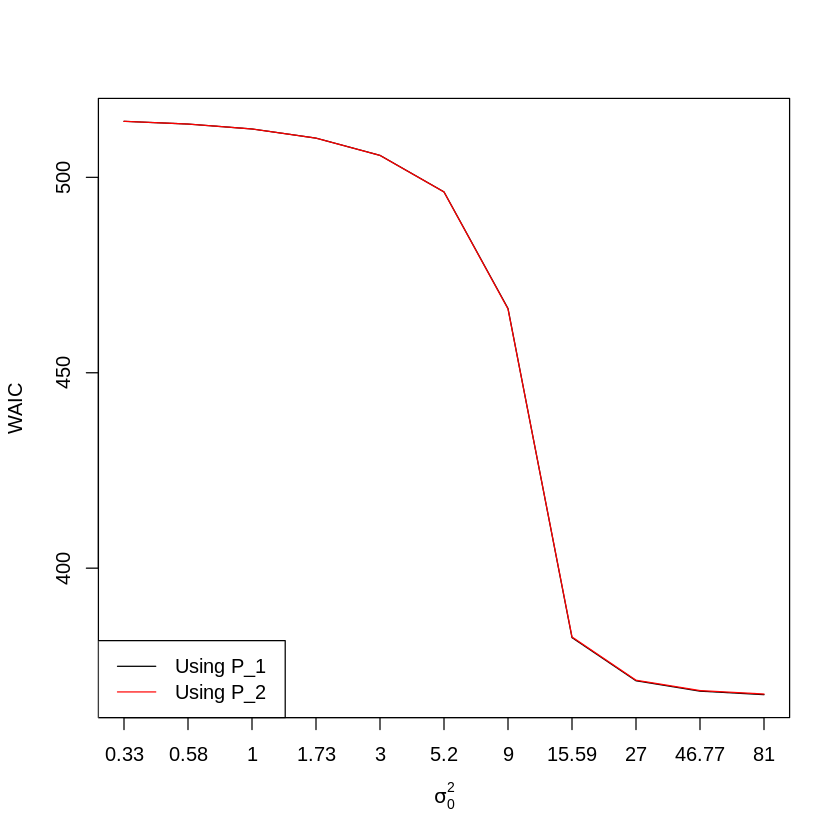

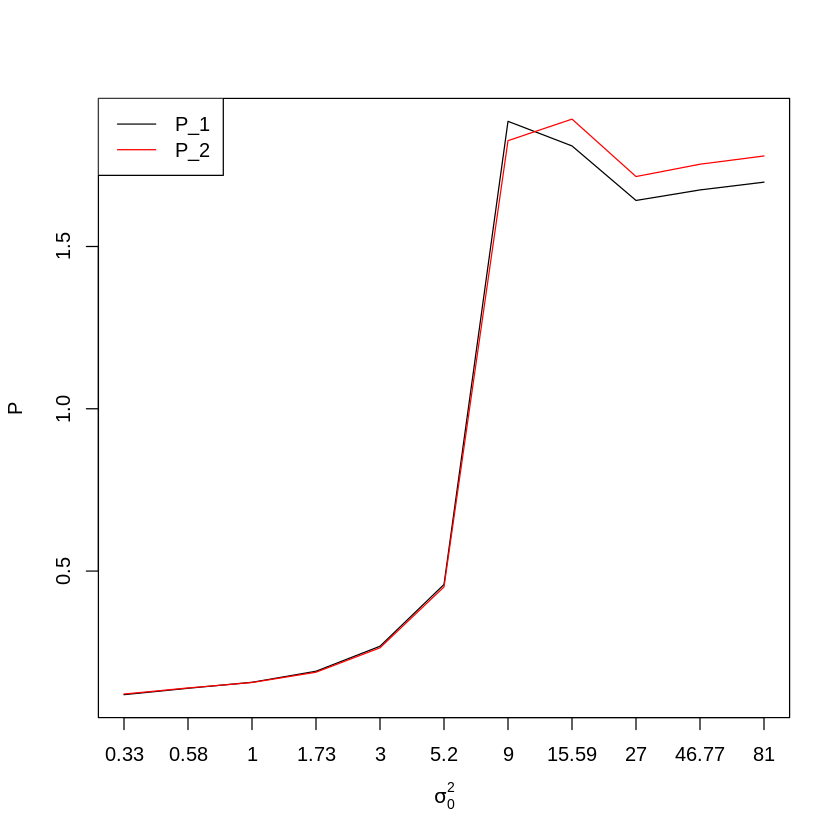

In [20]:

var0s = seq(1, 6, 0.5) - 2
var0s = 3 ^ var0s

P_1s = P_2s = WAIC_1s = WAIC_2s = rep(NA, length(var0s))

for (i in 1:length(var0s)) {
	theta_post_constrained = getPosteriorSamples(10000, mu0=0, var0=var0s[i], a0=0.1, b0=0.1)	

	res = calculate_WAIC(y, theta_post_constrained, likelihood_singleY)
	
	P_1s[i] = res$P_1
	P_2s[i] = res$P_2
	
	WAIC_1s[i] = res$WAIC_1
	WAIC_2s[i] = res$WAIC_2
}

plot(WAIC_1s, axes=FALSE, type='l', xlab=bquote(sigma[0]^2), ylab="WAIC")
lines(WAIC_2s, col="red")
box()
axis(2)
axis(1, at = 1:length(var0s), labels = round(var0s, 2))
legend("bottomleft", legend=c("Using P_1", "Using P_2"), lty=1, col=c("black", "red"))


plot(P_1s, axes=FALSE, type='l', xlab=bquote(sigma[0]^2), ylab="P")
lines(P_2s, col="red")
box()
axis(2)
axis(1, at = 1:length(var0s), labels = round(var0s, 2))
legend("topleft", legend=c("P_1", "P_2"), lty=1, col=c("black", "red"))





## Conclusion

WAIC is a measure of model fit that can be applied to Bayesian models and that works when the parameter estimation is done using numerical techniques, such as Gibbs samplers. WAIC has the nice advantage of being usable even when the posterior mean of parameters is meaningless or unsuable for whatever reason.

